In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# --- 1. Load Data and Prepare Fraud/Non-Fraud Tensors ---

# Load preprocessed X_train and y_train from CSV files.
X_train_df = pd.read_csv("Data/processed/X_train.csv")
y_train_df = pd.read_csv("Data/processed/y_train.csv")

# Convert y_train to a Series (assume the column name is "is_fraud")
y_train = y_train_df.iloc[:, 0]

# Create boolean masks for fraud (label = 1) and non-fraud (label = 0)
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Select rows from X_train corresponding to fraud and non-fraud
X_fraud_np = X_train_df.loc[fraud_mask].values
X_nonfraud_np = X_train_df.loc[nonfraud_mask].values

# Convert the NumPy arrays to PyTorch tensors of type float32.
X_fraud = torch.tensor(X_fraud_np, dtype=torch.float32)
X_nonfraud = torch.tensor(X_nonfraud_np, dtype=torch.float32)

In [4]:
# --- 2. Set Device and Move Tensors to Device ---

# Use CUDA if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the tensors to GPU for consistency.
X_fraud = X_fraud.to(device)
X_nonfraud = X_nonfraud.to(device)

print("X_fraud shape:", X_fraud.shape)
print("X_nonfraud shape:", X_nonfraud.shape)

Using device: cuda
X_fraud shape: torch.Size([6273, 19])
X_nonfraud shape: torch.Size([1197782, 19])


In [5]:
# --- 3. Diffusion Hyperparameters and Schedule ---

T_train = 800              # Number of diffusion steps during training
beta_start = 1e-4          # Starting noise variance
beta_end = 0.02            # Ending noise variance
beta = torch.linspace(beta_start, beta_end, T_train).to(device)  # Shape: (T_train,)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)  # Cumulative product for noise schedule

# Loss weights (as per the paper)
w1 = 0.2   # Weight for probability-based loss (L_prior)
w2 = 0.6   # Weight for triplet loss (contrastive)

In [6]:
# --- 4. Noise Prediction Model (MLP) ---

class NoisePredictor(nn.Module):
    """
    A simple MLP that predicts the noise added at each diffusion step.
    It takes the noised sample (x_t) and a normalized timestep (t) as input.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super(NoisePredictor, self).__init__()
        # Add 1 to input_dim to incorporate the normalized timestep.
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x, t):
        # Normalize timestep t to the range [0, 1]
        t_norm = t.unsqueeze(1).float() / T_train  # shape: (batch_size, 1)
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

In [7]:
# --- 5. Compute Adaptive Non-Fraud Prior --
# Compute the mean and standard deviation (diagonal covariance) using X_nonfraud.
mu_nf = X_nonfraud.mean(dim=0, keepdim=True).to(device)
sigma_nf = X_nonfraud.std(dim=0, keepdim=True).to(device) + 1e-5  # Avoid division by zero

In [8]:
# --- 6. Define Helper Functions and Losses ---

def forward_diffusion(x0, t):
    """
    For a given input x0 and timestep t, compute the noised sample x_t 
    using the closed-form solution of the forward diffusion process.
    """
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)         # Shape: (batch, 1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    """Mean squared error (MSE) loss between predicted and true noise."""
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    """
    Computes the probability-based loss (L_prior) using the adaptive 
    non-fraud prior via a two-tailed z-score.
    """
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)  # Tail probability P(Z >= |z|)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    """
    Computes the triplet loss to ensure the generated (denoised) sample 
    (anchor) is closer to a real fraud sample (positive) than to a non-fraud sample (negative).
    """
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

In [8]:
# --- 7. Train the FraudDiffuse Model ---

# Create a DataLoader for fraud samples.
batch_size = 40
fraud_dataset = TensorDataset(X_fraud)
loader = DataLoader(fraud_dataset, batch_size=batch_size, shuffle=True)
num_epochs = 150

# Initialize the noise predictor model.
input_dim = X_fraud.shape[1]
model = NoisePredictor(input_dim=input_dim, hidden_dim=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training…")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        # Real fraud samples
        x0 = batch[0]  # Shape: (batch_size, input_dim)
        current_batch_size = x0.shape[0]
        
        # Sample a random timestep t for each batch element.
        t = torch.randint(0, T_train, (current_batch_size,), device=device)
        
        # Compute the noised sample and true noise.
        x_t, true_noise = forward_diffusion(x0, t)
        
        # Predict noise using the model.
        pred_noise = model(x_t, t)
        
        # L_norm loss: MSE between predicted and true noise.
        L_norm = compute_Lnorm(pred_noise, true_noise)
        
        # L_prior loss: probability loss using adaptive prior.
        L_prior = compute_Lprior(pred_noise)
        
        # Approximate reverse diffusion to estimate x0 (denoised).
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        x0_est = (x_t - sqrt_one_minus_alpha_hat_t * pred_noise) / sqrt_alpha_hat_t
        
        # For triplet loss, sample negatives from X_nonfraud.
        neg_indices = torch.randint(0, X_nonfraud.shape[0], (current_batch_size,), device=device)
        negative_sample = X_nonfraud[neg_indices]
        L_triplet = triplet_loss(x0_est, x0, negative_sample)
        
        # Total loss: sum of losses weighted appropriately.
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Starting training…
Epoch [1/150], Loss: 4.5026
Epoch [2/150], Loss: 1.1577
Epoch [3/150], Loss: 1.1235
Epoch [4/150], Loss: 1.0776
Epoch [5/150], Loss: 1.0749
Epoch [6/150], Loss: 1.0282
Epoch [7/150], Loss: 0.9517
Epoch [8/150], Loss: 0.9337
Epoch [9/150], Loss: 0.9104
Epoch [10/150], Loss: 0.8815
Epoch [11/150], Loss: 0.8487
Epoch [12/150], Loss: 0.8480
Epoch [13/150], Loss: 0.8292
Epoch [14/150], Loss: 0.8076
Epoch [15/150], Loss: 0.7808
Epoch [16/150], Loss: 0.7785
Epoch [17/150], Loss: 0.7613
Epoch [18/150], Loss: 0.7610
Epoch [19/150], Loss: 0.7585
Epoch [20/150], Loss: 0.7426
Epoch [21/150], Loss: 0.7453
Epoch [22/150], Loss: 0.7387
Epoch [23/150], Loss: 0.7328
Epoch [24/150], Loss: 0.7305
Epoch [25/150], Loss: 0.7275
Epoch [26/150], Loss: 0.6958
Epoch [27/150], Loss: 0.7370
Epoch [28/150], Loss: 0.7128
Epoch [29/150], Loss: 0.7087
Epoch [30/150], Loss: 0.6958
Epoch [31/150], Loss: 0.6817
Epoch [32/150], Loss: 0.7121
Epoch [33/150], Loss: 0.6931
Epoch [34/150], Loss: 0.6845
Epoc

In [9]:
# --- 8. Save the Trained Model ---
torch.save(model.state_dict(), "fraud_diffuse_model.pth")
print("Training complete. Model saved as 'fraud_diffuse_model.pth'.")

Training complete. Model saved as 'fraud_diffuse_model.pth'.


In [9]:
# Set device (ensure this matches your training setup)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model instance with the same architecture and parameters as during training
# Replace `input_dim`, `hidden_dim`, and `output_dim` with your actual configuration.
model = NoisePredictor(input_dim=19, hidden_dim=256).to(device)

In [10]:
model.load_state_dict(torch.load("fraud_diffuse_model.pth", map_location=device))
model.eval() # set the model to evaluation mode

NoisePredictor(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=19, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)

In [11]:
# --- Step 1: Generate Synthetic Fraud Samples via Reverse Diffusion ---

def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    """
    Generate synthetic fraud samples using the reverse diffusion process.
    
    Parameters:
      model       : the trained noise predictor model
      num_samples : number of synthetic samples to generate
      T_gen       : total number of diffusion steps (use same as training T_train)
      
    Returns:
      x0 : synthetic fraud samples (tensor of shape [num_samples, input_dim])
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Sample initial x_T from the adaptive non-fraud prior: N(mu_nf, sigma_nf)
        # Use broadcasting to sample num_samples samples. 
        noise = torch.randn(num_samples, X_fraud.shape[1]).to(device)
        x_t = mu_nf.repeat(num_samples, 1) + sigma_nf.repeat(num_samples, 1) * noise

        # Iteratively perform the reverse diffusion process.
        # For t = T_gen-1 down to 1:
        for t_step in reversed(range(1, T_gen)):
            # Create a tensor filled with the current timestep
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            # Predict the noise using our trained model.
            pred_noise = model(x_t, t)
            # Retrieve beta and related terms for the current timesteps.
            # Note: beta, alpha, and alpha_hat were computed during training.
            beta_t = beta[t].unsqueeze(1)                     # (num_samples, 1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)    # (num_samples, 1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            
            # For t > 1, add additional randomness; for t == 1, set noise z = 0.
            z = torch.randn_like(x_t) if t_step > 1 else torch.zeros_like(x_t)
            
            # Update rule (based on a typical DDPM reverse update):
            # x_{t-1} = 1/sqrt(alpha_t) * ( x_t - (beta_t/sqrt(1 - alpha_hat_t)) * pred_noise ) + sqrt(beta_t)*z
            x_t = (x_t - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise) / sqrt_alpha_t + torch.sqrt(beta_t) * z

        # x_t now approximates x_0, the synthetic fraud sample
        return x_t

# Using the generation function:
num_synthetic = 100  # Number of synthetic fraud samples you want to generate.
synthetic_frauds = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic fraud samples shape:", synthetic_frauds.shape)

Synthetic fraud samples shape: torch.Size([100, 19])


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

synthetic_np = synthetic_frauds.cpu().numpy()
real_fraud_np = X_fraud.cpu().numpy() # Real fraud samples from training data

In [13]:
synthetic_np

array([[ 1.27312246e+04,  3.60358032e+02, -5.26110382e+01, ...,
        -1.25822458e+01,  1.01694176e+02, -8.37244225e+00],
       [ 3.97505884e+03,  4.90628510e+02, -5.70909195e+01, ...,
        -6.56880722e+01, -4.96969833e+01,  9.45113525e+01],
       [ 2.56505176e+04,  2.91901947e+02, -5.93811989e+01, ...,
        -7.59397278e+01, -4.26896820e+01,  3.84712448e+01],
       ...,
       [ 1.10840293e+04,  4.26321228e+02,  9.92616425e+01, ...,
        -4.48873711e+01,  2.62928696e+01,  5.16412926e+01],
       [-5.48108301e+03,  3.99123726e+01, -9.50462494e+01, ...,
        -2.73278866e+01,  4.94132690e+01, -1.72719746e+01],
       [ 3.52389570e+04,  3.34579895e+02, -4.07561981e+02, ...,
        -1.20634468e+02, -1.19239761e+02, -1.32495026e+02]], dtype=float32)

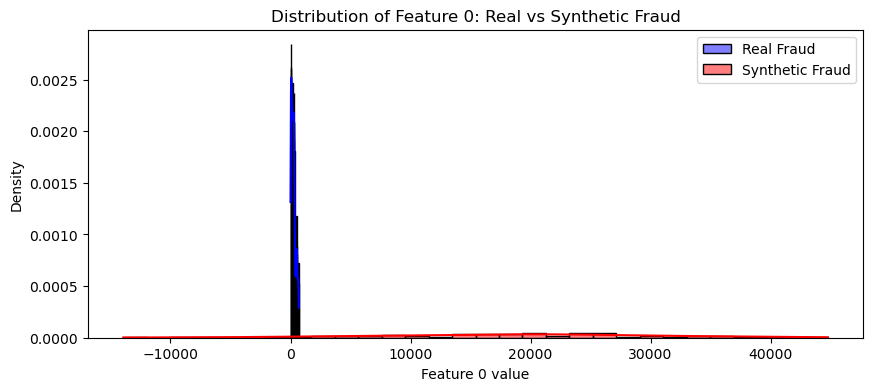

In [14]:
col = 0
plt.figure(figsize=(10, 4))
sns.histplot(real_fraud_np[:, col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
sns.histplot(synthetic_np[:, col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
plt.legend()
plt.title(f'Distribution of Feature {col}: Real vs Synthetic Fraud')
plt.xlabel(f'Feature {col} value')
plt.ylabel('Density')
plt.show()

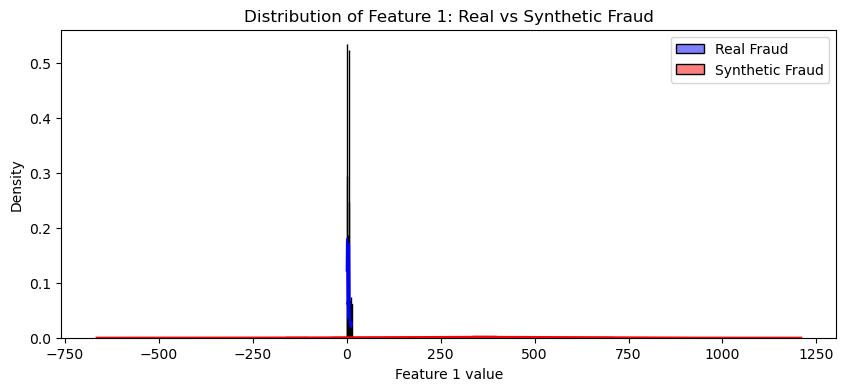

In [19]:
col = 1
plt.figure(figsize=(10, 4))
sns.histplot(real_fraud_np[:, col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
sns.histplot(synthetic_np[:, col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
plt.legend()
plt.title(f'Distribution of Feature {col}: Real vs Synthetic Fraud')
plt.xlabel(f'Feature {col} value')
plt.ylabel('Density')
plt.show()

In [18]:
import pandas as pd

num_features = real_fraud_np.shape[1]
columns = [f"F{i}" for i in range(num_features)]
real_df = pd.DataFrame(real_fraud_np, columns=columns)
synthetic_df = pd.DataFrame(synthetic_np, columns=columns)

print("Real Fraud Statistics:")
print(real_df.describe())

print("\n" + "="*50 + "\n")

print("Synthetic Fraud Statistics:")
print(synthetic_df.describe())

Real Fraud Statistics:
                F0           F1           F2           F3           F4  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean    242.449066     4.408257     1.569536     0.493863   500.800415   
std     177.679779     3.582832     1.263539     0.500007   286.820953   
min       0.000000     0.000000    -2.180321     0.000000     0.000000   
25%      95.000000     1.000000     1.512012     0.000000   251.000000   
50%     216.000000     4.000000     1.883656     0.000000   503.000000   
75%     330.000000     7.000000     2.539076     1.000000   743.000000   
max     692.000000    13.000000     2.868764     1.000000   998.000000   

                F5          F6           F7           F8           F9  \
count  6273.000000  6273.00000  6273.000000  6273.000000  6273.000000   
mean    439.567047    22.14953   491.675751     0.035681     0.003129   
std     259.891357    13.03732   282.970795     1.006742     1.033924   
min       0.000000